In [1]:
# Importing required libraries
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# 1. Load the dataset from a CSV file
df = pd.read_csv("Bank_Loan.csv")  # Load the bank loan dataset
df = df.drop(columns=['ZIP Code'])  # Drop ZIP Code column (not useful for prediction)

In [3]:
# 2. Separate features (X) and target/label (y)
X = df.drop(columns=['Personal Loan'])  # All columns except the target
y = df['Personal Loan']  # Target: 0 = no loan, 1 = took loan

In [4]:
# 3. Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 4. Normalize features using StandardScaler (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data and transform
X_test = scaler.transform(X_test)        # Transform test data with the same scaler

In [6]:
# 5. Convert all data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Convert y to column vector
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [7]:
# 6. Custom Dataset class for PyTorch DataLoader
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# Create the DataLoader for batching and shuffling the training data
train_dataset = LoanDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
# 8. Neural Network Model with ReLU Activation
class LoanModel(nn.Module):
    def __init__(self):
        super(LoanModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 16),  # Input to hidden layer 1
            nn.ReLU(),                        # ReLU activation
            nn.Linear(16, 8),                 # Hidden layer 1 to hidden layer 2
            nn.ReLU(),                        # ReLU activation
            nn.Linear(8, 1),                  # Hidden layer 2 to output
            nn.Sigmoid()                      # Sigmoid for binary output
        )

    def forward(self, x):
        return self.net(x)

In [10]:
# 9. Initialize the model, define loss function and optimizer
model = LoanModel()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [ ]:
# 10. Training loop (50 epochs) with tracking of loss and accuracy
loss_values = []
accuracy_values = []

for epoch in range(20):
    model.train()  # Set model to training mode
    epoch_loss = 0

    # Iterate through each batch
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)            # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        epoch_loss += loss.item()  # Track total loss

    # Calculate average loss per epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)  # Save for plotting

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_predicted = (val_preds > 0.5).float()  # Convert probabilities to binary class
        val_accuracy = (val_predicted == y_test).sum() / y_test.shape[0]  # Compute accuracy
        accuracy_values.append(val_accuracy.item())  # Save for plotting

    # Print epoch summary
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {val_accuracy.item():.4f}')

Epoch 0, Loss: 0.6420, Accuracy: 0.8950
Epoch 1, Loss: 0.3405, Accuracy: 0.8970
Epoch 2, Loss: 0.1996, Accuracy: 0.9270
Epoch 3, Loss: 0.1508, Accuracy: 0.9550
Epoch 4, Loss: 0.1235, Accuracy: 0.9670
Epoch 5, Loss: 0.1062, Accuracy: 0.9690
Epoch 6, Loss: 0.0946, Accuracy: 0.9760
Epoch 7, Loss: 0.0870, Accuracy: 0.9750
Epoch 8, Loss: 0.0810, Accuracy: 0.9810
Epoch 9, Loss: 0.0768, Accuracy: 0.9800
Epoch 10, Loss: 0.0731, Accuracy: 0.9810
Epoch 11, Loss: 0.0704, Accuracy: 0.9800
Epoch 12, Loss: 0.0682, Accuracy: 0.9800
Epoch 13, Loss: 0.0664, Accuracy: 0.9800
Epoch 14, Loss: 0.0651, Accuracy: 0.9810
Epoch 15, Loss: 0.0630, Accuracy: 0.9820
Epoch 16, Loss: 0.0618, Accuracy: 0.9820
Epoch 17, Loss: 0.0605, Accuracy: 0.9820
Epoch 18, Loss: 0.0592, Accuracy: 0.9830
Epoch 19, Loss: 0.0587, Accuracy: 0.9830


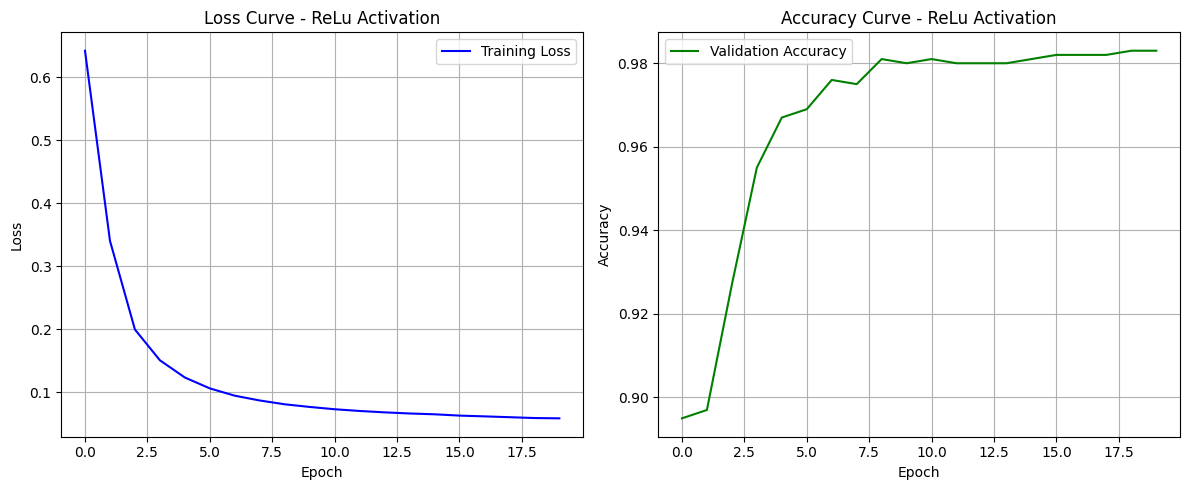

In [12]:
# 11. Plot Loss and Accuracy curves
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve - ReLu Activation")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve - ReLu Activation")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# 12. Final model evaluation on test data
with torch.no_grad():
    preds = model(X_test)                     # Get predictions
    predicted = (preds > 0.5).float()         # Convert probabilities to 0 or 1
    accuracy = (predicted == y_test).sum() / y_test.shape[0]  # Calculate final accuracy
    print(f'\nFinal Test Accuracy: {accuracy.item():.4f}')


Final Test Accuracy: 0.9830


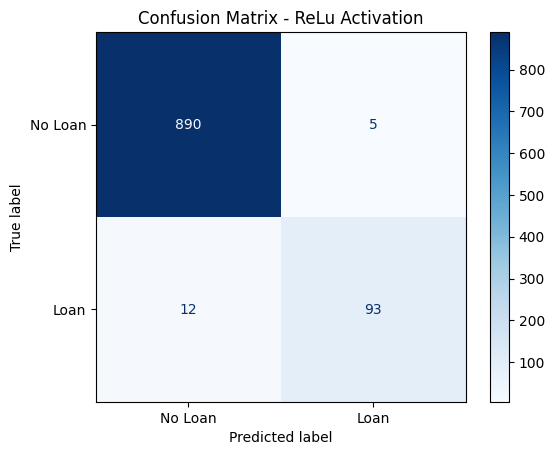

In [14]:
# 13. Confusion Matrix Visualization
cm = confusion_matrix(y_test.numpy().astype(int), predicted.numpy().astype(int))  # Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Loan", "Loan"])
disp.plot(cmap='Blues')  # Display matrix with color
plt.title("Confusion Matrix - ReLu Activation")
plt.show()